## This is based on `old_scripts/extract_other_coords` and `old_scripts/parse_other_coords`

Jupyter notebooks are just as fast as python so there is no reason to not do it here, then it will be easy to compare. I basically want to be able to put other CVs into the MSM

So, I have to calculate these CVs! 

As in `extract_other_coords` I will measure iteration, per swarm, per bead for the MSM. I am not so sure the order actually matters since we project in TICA space, but anyway. Why not :) 

 **The shape of these CVs must be**: `(n_iterations*n_swarms_per_iter*n_beads, n_frames_per_swarm, n_cvs)`


Since bead points 0 and 15 are fixed, we only want to calculate for the beads 1 - 14

## I run this locally, I have trajectories in each md/iteration directory for all beads, all swarms. It's in the right order, though I don't think that matters

In [1]:
import MDAnalysis as mda
import numpy as np
from MDAnalysis.analysis import distances as d
from MDAnalysis.analysis import rms
import matplotlib.pyplot as plt
from scipy.linalg import norm
import seaborn as sns

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [2]:
run_atom_calc=False

In [3]:
if run_atom_calc:
    atom_sims = ['OUT', 'OUT-OCC', 'OCC', 'IN-OCC', 'IN']

    features_sims = []
    for atom_sim in atom_sims:
        u = mda.Universe(f'../ref_models_protonly/{atom_sim}.start.protonly.gro')
        features_sims.append(get_salt_br(u,res1_n='resid 136-145', res2_n='resid 386-394'))

    features_sims = np.array(features_sims)
    np.save('../textfiles_out/not_gates_for_MSM/atom_sims.IC_mindist.angstrom.npy', features_sims)

## simulation processing

OG cv coords are shaped as `[n_iterations*n_beads*n_swarms,  n_frames_per_swarm,   n_cvs]`

So, `cv_coordinates` looks like this:


```
array([[[1.44185 , 1.03851 ],
        [1.45534 , 1.03668 ]],

       [[1.44185 , 1.03851 ],
        [1.41444 , 1.0381  ]],
        ...
```
ie
```
array([[EC_start_swarm0,   IC_start_swarm0],
       [EC_end_swarm0,     IC_end_swarm0]],
       
       [EC_start_swarm1,   IC_start_swarm1],
       [EC_end_swarm1,     IC_end_swarm1]],
       ...

```

To achieve this, use `np.dstack`

In the simplest case, you combine two cvs, and spit that out.

If you are keeping sort of the same "L" shape, then use "EC" gate representative as `cv1` in the `dstack`, and "IC" gate rep as `cv2`, as these will get reordered during the projection of MSM. It's not like you must do this, doesn't matter for MSM, but then you don't have to remember to uncomment `cv_proj` transformation

In [54]:
condition='influx_BFRU_gate_CV'

In [74]:
tm7 = np.load(f'../textfiles_out/not_gates_for_MSM/{condition}.TM7_angle.npy')
tm10 = np.load(f'../textfiles_out/not_gates_for_MSM/{condition}.get_TM10_RMSD.npy')
salt_br1 = np.load(f'../textfiles_out/not_gates_for_MSM/{condition}.salt_br1.charged.npy')
salt_br2 = np.load(f'../textfiles_out/not_gates_for_MSM/{condition}.salt_br2.charged.npy')
salt_br_mean = np.mean([salt_br1, salt_br2], axis=0)
#np.save(f'../textfiles_out/not_gates_for_MSM/{condition}.salt_br_mean.npy', salt_br_mean)
#y_to_h=np.load(f'../textfiles_out/not_gates_for_MSM/{condition}.Y296_H386.npy')
#EC_mindist=np.load(f'../textfiles_out/not_gates_for_MSM/{condition}.EC_mindist.angstrom.npy')
#IC_mindist=np.load(f'../textfiles_out/not_gates_for_MSM/{condition}.IC_mindist.angstrom.npy')
#EC_contacts=np.load(f'../textfiles_out/not_gates_for_MSM/{condition}.EC_n_contacts.npy')
#IC_contacts=np.load(f'../textfiles_out/not_gates_for_MSM/{condition}.IC_n_contacts.npy')
#EC_contacts=np.load(f'../textfiles_out/not_gates_for_MSM/{condition}.EC_n_res_contacts.npy')
#IC_contacts=np.load(f'../textfiles_out/not_gates_for_MSM/{condition}.IC_n_res_contacts.npy')


#darko_state = 'lda_cvs'
#darko_cv1 = np.load(f'../textfiles_out/not_gates_for_MSM/darko_cvs/influx_BFRU_gate_CV.{darko_state}.darko_cv1.npy')
#darko_cv2 = np.load(f'../textfiles_out/not_gates_for_MSM/darko_cvs/influx_BFRU_gate_CV.{darko_state}.darko_cv2.npy')
darko_cv1 = np.load(f'../textfiles_out/not_gates_for_MSM/darko_cvs/{condition}.lda_cvs1.npy')
darko_cv2 = np.load(f'../textfiles_out/not_gates_for_MSM/darko_cvs/{condition}.lda_cvs2.npy')


atom_tm7=np.load(f'../textfiles_out/not_gates_for_MSM/atom_sims.TM7_angle.npy')
atom_tm10=np.load(f'../textfiles_out/not_gates_for_MSM/atom_sims.TM10_RMSD.npy')
atom_salt_br1=np.load(f'../textfiles_out/not_gates_for_MSM/atom_sims.salt_br1.npy')
atom_salt_br2=np.load(f'../textfiles_out/not_gates_for_MSM/atom_sims.salt_br2.npy')
atom_salt_br_mean=np.mean([atom_salt_br1,atom_salt_br2], axis=0)
atom_y_to_h=np.load(f'../textfiles_out/not_gates_for_MSM/atom_sims.Y296_H386.npy')
atom_EC_mindist=np.load(f'../textfiles_out/not_gates_for_MSM/atom_sims.EC_mindist.angstrom.npy')
atom_IC_mindist=np.load(f'../textfiles_out/not_gates_for_MSM/atom_sims.IC_mindist.angstrom.npy')
np.save(f'../textfiles_out/not_gates_for_MSM/atom_sims.salt_br_mean.npy', atom_salt_br_mean)

In [75]:
cv1 = salt_br_mean  #this will be x axis. I don't want to flip the coordinates in the MSM if I don't have to
cv2 = ec_gate  # y axis

In [76]:
np.shape(cv2)

(289408, 2)

In [77]:
cv_out = np.dstack([cv1,cv2])
np.save(f'../textfiles_out/not_gates_for_MSM/influx_BFRU_gate_CV.salt_br_charged_ec_gate.npy', cv_out)

In [45]:
np.save(f'../textfiles_out/not_gates_for_MSM/influx_BFRU_gate_CV.IC_EC_n_res_contacts.npy', cv_out)

In [6]:
def kde_overlay(cv_coords,atom_plot=False, atom_sim=None):
    sns.kdeplot(cv_coords[:,1])
    if not atom_plot:
        pass
    if atom_plot:
        for n in np.arange(0,len(atom_sims)):
            plt.scatter(atom_sim[n], 0.03, label=atom_sims[n])
    plt.legend() 

In [57]:
cv_proj = np.load('../../string_sims/TMD_initial_path/influx_apo_gate_CV/cv_proj_MSM.npy')
ic_gate = cv_proj[:,:,0]
ec_gate = cv_proj[:,:,1]
np.save('../textfiles_out/not_gates_for_MSM/influx_apo_gate_CV.EC_gate.npy', ec_gate)
np.save('../textfiles_out/not_gates_for_MSM/influx_apo_gate_CV.IC_gate.npy', ic_gate)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


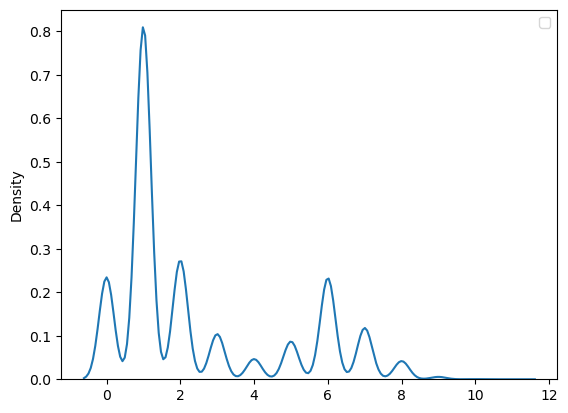

In [41]:
kde_overlay(EC_contacts)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


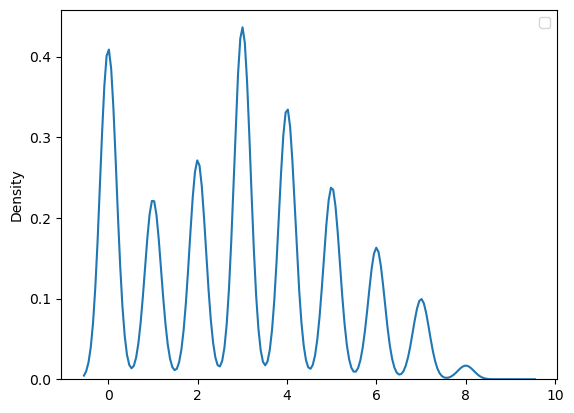

In [42]:
kde_overlay(IC_contacts)

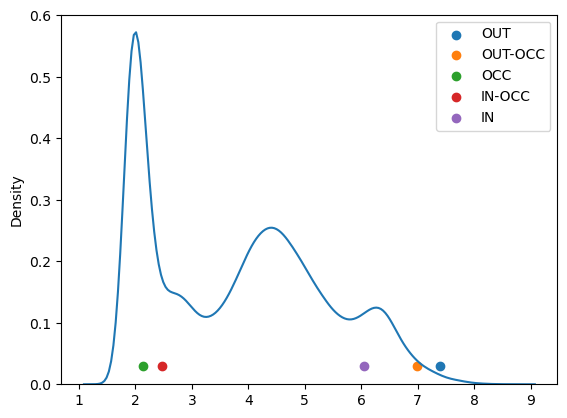

In [36]:
kde_overlay(y_to_h, atom_plot=True, atom_sim=atom_y_to_h)

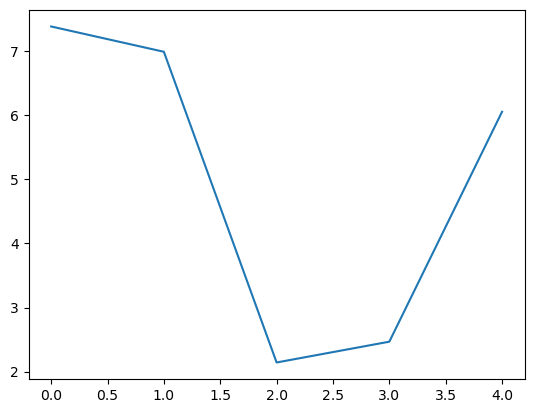

In [28]:
plt.plot(atom_y_to_h)

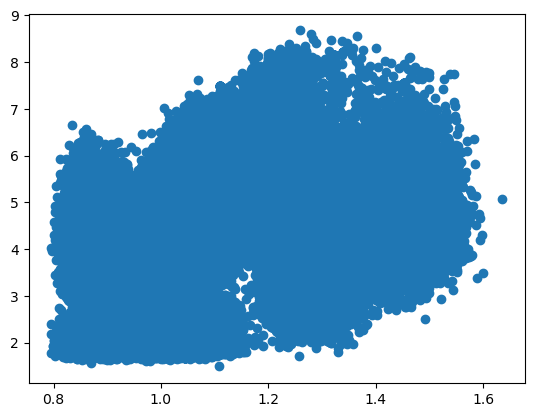

In [42]:
plt.scatter(ec_gate, y_to_h)

## just confirming that these simulations are in the right order, which they are :) 

You can compare to `pullx.xvg` when you get paranoid

In [54]:
tm1 = u.select_atoms('resid 30-37')
tm7 = u.select_atoms('resid 289-295')

test = np.zeros((1*14*32,2))

test_index = 0
for ts in u.trajectory:
    if ts.frame % 2 == 0:
        test[test_index][0] = d.distance_array(tm1.center_of_mass(),tm7.center_of_mass())
    else:
        test[test_index][1] = d.distance_array(tm1.center_of_mass(),tm7.center_of_mass())
        test_index = test_index+1